# **3. 레이블 데이터 (full_intent_labels.tsv)를 이용한 AI 모의 면접 시스템 구축**

## 1. 데이터 준비 및 모델 로드

- BERT 토크나이저와 사전 훈련된 모델을 로드
- 직무별 키워드, 카테고리 설명, 감정 사전 등을 정의

## 2. 주요 함수

- `predict()`: BERT 모델을 사용하여 문장의 카테고리, 표현, 설명, 직무를 예측
- `improved_sentiment_analysis()`: 감정 사전을 이용해 문장의 감정 점수를 계산
- `analyze_response()`: 문장에 대해 종합적인 분석을 수행
  - BERT 모델 예측
  - TF-IDF를 이용한 중요 단어 추출
  - 직무별 키워드 매칭
  - 감정 분석

## 3. 피드백 생성

- `generate_feedback()`: 분석 결과를 바탕으로 구조화된 피드백을 생성
  - 기본 정보 (카테고리, 역량/특성, 관련 직무)
  - 강점 (매칭된 키워드, 긍정적 표현)
  - 개선점 (누락된 키워드 제안)
  - 구체적인 피드백 (중요 단어에 기반한 상세 조언)
  - 결론 (전반적인 평가 및 조언)

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install koreanize_matplotlib
!fc-list | grep NanumGothic
!apt-get install fonts-nanum*dd

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 72.5 MB/s eta 0:00:00
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
E: Unable to locate package fonts-nanum*dd
E: Couldn't find any package by glob 'fonts-nanum*dd'
E: Couldn't find any package by regex 'fonts-nanum*dd'


In [4]:
import koreanize_matplotlib
import warnings
warnings.simplefilter(action='ignore', category=Warning)

In [5]:
!pip uninstall tensorflow
!pip install tensorflow==2.15.0
!pip install keras==2.15.0
!pip install transformers==4.35.0
!pip install keras-tuner

Found existing installation: tensorflow 2.17.0
Uninstalling tensorflow-2.17.0:
  Would remove:
    /usr/local/bin/import_pb_to_tensorboard
    /usr/local/bin/saved_model_cli
    /usr/local/bin/tensorboard
    /usr/local/bin/tf_upgrade_v2
    /usr/local/bin/tflite_convert
    /usr/local/bin/toco
    /usr/local/bin/toco_from_protos
    /usr/local/lib/python3.10/dist-packages/tensorflow-2.17.0.dist-info/*
    /usr/local/lib/python3.10/dist-packages/tensorflow/*
Proceed (Y/n)? Y
  Successfully uninstalled tensorflow-2.17.0
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 475.2/475.2 MB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 73.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 58.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 116.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 442.0/442.0 kB 32.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 6.6 MB/s eta 0:00:00
  At

In [6]:
import tensorflow as tf
import keras
import transformers

print(f"TensorFlow version: {tf.__version__}")
print(f"Keras version: {keras.__version__}")
print(f"Transformers version: {transformers.__version__}")

TensorFlow version: 2.15.0
Keras version: 2.15.0
Transformers version: 4.35.0


In [7]:
!pip install konlpy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.4/19.4 MB 93.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 488.6/488.6 kB 34.1 MB/s eta 0:00:00


In [8]:
import tensorflow as tf
from tensorflow.keras.models import load_model
from transformers import BertTokenizer, TFBertModel
import numpy as np
import pandas as pd
from konlpy.tag import Okt
from sklearn.feature_extraction.text import TfidfVectorizer

In [9]:
# BERT 토크나이저 및 모델 로드
tokenizer = BertTokenizer.from_pretrained("klue/bert-base")
custom_objects = {'TFBertModel': TFBertModel}
with tf.keras.utils.custom_object_scope(custom_objects):
    model = load_model('/content/drive/MyDrive/Colab Notebooks/Project(InterviewData-Analysis)/Models/best_intent_model.h5')

In [10]:
# 한국어 형태소 분석기 초기화
okt = Okt()

# 설정
max_len = 128  # 최대 문장 길이

In [11]:
# 레이블 데이터 로드
full_intent_labels = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Project(InterviewData-Analysis)/data/full_intent_labels.tsv", sep="\t", encoding="utf8")
full_intent_labels

,category,expression,label,description,job
0,attitude,d_creative,0,창의적 사고,예술/디자인
1,attitude,d_express,1,표현력,예술/디자인
2,attitude,d_sens,2,감수성,예술/디자인
3,attitude,f_cons,3,성실성,제조/생산
4,attitude,f_pat,4,끈기,R&D(개발/제조)
5,attitude,f_resp,5,책임감,제조/생산
6,attitude,i_hwsw_prfi,6,HW/SW 이해,ICT
7,attitude,i_secty,7,정보보안,ICT
8,attitude,i_tech_orien,8,ICT 기술 지향성,ICT
9,attitude,m_critical,9,비판적 사고,영업/판매


<직무별 키워드 참고 자료>
- 한국직업능력개발원의 NCS(국가직무능력표준) 자료:
https://www.ncs.go.kr/
- LinkedIn의 "The Skills Companies Need Most" 연간 보고서:
https://business.linkedin.com/talent-solutions/blog/trends-and-research/2020/most-in-demand-hard-and-soft-skills

<감정 사전 참고 자료>
- 국립국어원의 "한국어 감성 사전" 프로젝트:
https://www.korean.go.kr/front/board/boardStandardView.do?board_id=4&mn_id=17&b_seq=464
- KOSAC(Korean Sentiment Analysis Corpus) 프로젝트:
http://word.snu.ac.kr/kosac/

<불용어 목록 참고 자로>
- 국립국어원의 "한국어 말뭉치" 자료:
https://corpus.korean.go.kr/

In [12]:
# 직무별 키워드, 카테고리 설명, 감정 사전 정의
# 직무별 키워드 정의
job_keywords = {
    "경영/사무": ["분석", "전략", "의사소통", "성과", "브랜드", "세일즈", "대인관계", "기획", "관리", "목표", "리더십"],
    "공공/서비스": ["고객", "서비스", "윤리", "주도성", "스트레스", "대응", "VOC", "민원", "공익", "정책", "협력"],
    "R&D(개발/제조)": ["연구", "기술", "문제해결", "전문성", "정보수집", "방법론", "실적", "혁신", "개발", "실험", "분석"],
    "예술/디자인": ["창의", "트렌드", "감각", "표현", "브랜드", "프로세스", "선호", "미적", "시각", "컨셉", "아이디어"],
    "영업/판매": ["조율", "회계", "행정", "목표", "총괄", "비판적", "경험", "협상", "고객관리", "마케팅", "실적"],
    "ICT": ["프로그래밍", "개발", "장애대응", "기술", "보안", "HW", "SW", "네트워크", "데이터", "알고리즘", "시스템"],
    "제조/생산": ["교대근무", "생산계획", "장비운용", "성실성", "책임감", "품질관리", "안전", "효율성", "공정", "재고관리"]
}

# 카테고리 설명
category_descriptions = {
    "attitude": "태도 관련 역량",
    "background": "배경 및 경험",
    "etc": "기타 관련 사항",
    "personality": "성격 및 개인적 특성",
    "technology": "지식/기술 관련 역량"
}

# 한국어 감정 사전
korean_sentiment_dict = {
    '좋은': 2, '훌륭한': 2, '열정적인': 2, '성공적인': 2, '효과적인': 2, '향상': 2, '달성': 2,
    '노력': 1, '원활': 1, '조율': 1, '협력': 1, '개선': 1, '발전': 1, '성장': 1,
    '높였습니다': 2, '기여했습니다': 2, '적용': 1, '새로운': 1, '창의적': 2,
    '나쁜': -2, '어려운': -1, '힘든': -1, '실패한': -2, '비효율적인': -2, '부족한': -1
}

# 불용어 목록
stop_words = ['있다', '없다', '하다', '되다', '이다', '돼다', '않다', '같다', '이', '그', '저', '것', '들', '등', '를', '을', '에', '의', '과', '로', '으로']

In [ ]:
def predict(sentence):
    """
    주어진 문장에 대해 예측을 수행하는 함수

    Args:
        sentence (str): 예측할 문장

    Returns:
        tuple: (category, expression, description, job)
    """
    # 토큰화
    inputs = tokenizer(
        sentence,
        max_length=max_len,
        padding='max_length',
        truncation=True,
        return_tensors='tf'
    )

    # 모델 예측
    out = model({'input_ids': inputs['input_ids'], 'attention_mask': inputs['attention_mask']})

    logits = out.numpy()
    predicted_class = np.argmax(logits, axis=1)[0]

    # 예측 결과 해석
    prediction_info = full_intent_labels.iloc[predicted_class]
    category = prediction_info['category']
    expression = prediction_info['expression']
    description = prediction_info['description']
    job = prediction_info['job']

    return category, expression, description, job

In [ ]:
def improved_sentiment_analysis(text):
    """
    주어진 텍스트의 감정 점수를 계산하는 함수

    Args:
        text (str): 분석할 텍스트

    Returns:
        int: 감정 점수
    """
    words = okt.morphs(text)
    score = sum(korean_sentiment_dict.get(word, 0) for word in words)

    # 긍정적인 문장 패턴 검사
    positive_patterns = ['을 높였습니다', '에 기여했습니다', '을 달성했습니다']
    for pattern in positive_patterns:
        if pattern in text:
            score += 2

    return score

In [ ]:
def analyze_response(sentence):
    """
    주어진 문장에 대해 종합적인 분석을 수행하는 함수

    Args:job_keywords
        sentence (str): 분석할 문장

    Returns:
        dict: 분석 결과
    """
    category, expression, description, job = predict(sentence)

    # TF-IDF 분석
    tfidf = TfidfVectorizer(max_features=10, stop_words=stop_words)
    tfidf_matrix = tfidf.fit_transform([sentence])
    important_words = tfidf.get_feature_names_out()

    # 직무별 키워드
    matched_keywords = [keyword for keyword in job_keywords.get(job, []) if keyword in sentence]
    all_matched_keywords = [keyword for job_kw in job_keywords.values() for keyword in job_kw if keyword in sentence]

    # 감정 분석
    sentiment = improved_sentiment_analysis(sentence)

    return {
        'category': category,
        'expression': expression,
        'job': job,
        'description': description,
        'important_words': important_words,
        'matched_keywords': matched_keywords,
        'all_matched_keywords': all_matched_keywords,
        'sentiment': sentiment
    }

In [ ]:
def generate_feedback(analysis_result):
    """분석 결과를 바탕으로 피드백을 생성하는 함수"""
    feedback_parts = [
        generate_basic_info(analysis_result),
        generate_strengths(analysis_result),
        generate_improvements(analysis_result),
        generate_specific_feedback(analysis_result),
        generate_conclusion(analysis_result)
    ]
    return "\n".join(feedback_parts)

In [ ]:
def generate_basic_info(analysis_result):
    """기본 정보 피드백 생성"""
    category = analysis_result['category']
    expression = analysis_result['expression']
    job = analysis_result['job']
    description = analysis_result['description']

    return f"""답변 카테고리: {category_descriptions.get(category, category)}
관련 역량/특성: {description} (표현: {expression})
관련 직무: {job}"""

In [ ]:
def generate_strengths(analysis_result):
    """강점 피드백 생성"""
    job = analysis_result['job']
    strengths = [f"- {keyword}와(과) 관련된 내용을 언급하여 {job} 직무에 대한 이해도를 보여주었습니다."
                 for keyword in analysis_result['matched_keywords']]

    other_keywords = set(analysis_result['all_matched_keywords']) - set(analysis_result['matched_keywords'])
    if other_keywords:
        strengths.append(f"- 다음 키워드들도 언급되어 다양한 역량을 보여주었습니다: {', '.join(other_keywords)}")

    sentiment_feedback = get_sentiment_feedback(analysis_result['sentiment'])
    if sentiment_feedback:
        strengths.append(sentiment_feedback)

    return "강점:\n" + "\n".join(strengths) if strengths else ""

In [ ]:
def get_sentiment_feedback(sentiment):
    """감정 분석 결과에 따른 피드백 생성"""
    if sentiment > 3:
        return "- 매우 긍정적이고 열정적인 태도가 잘 드러납니다."
    elif sentiment > 0:
        return "- 긍정적인 태도가 느껴집니다."
    elif sentiment == 0:
        return "- 중립적인 태도로 답변하셨습니다. 조금 더 적극적인 표현을 사용해보는 것은 어떨까요?"
    else:
        return "- 답변에 더 긍정적인 표현을 사용해 보는 것은 어떨까요?"

In [ ]:
def generate_improvements(analysis_result):
    """개선점 피드백 생성"""
    job = analysis_result['job']
    missing_keywords = set(job_keywords.get(job, [])) - set(analysis_result['matched_keywords'])
    improvements = [f"- {keyword}에 대한 언급을 추가하면 {job} 직무와의 연관성을 더 잘 보여줄 수 있습니다."
                    for keyword in list(missing_keywords)[:3]]

    return "개선점:\n" + "\n".join(improvements) if improvements else ""

In [ ]:
def generate_specific_feedback(analysis_result):
    """구체적인 피드백 생성"""
    sentence = ' '.join(analysis_result['important_words'])
    specific_feedback = []

    feedback_rules = {
        '프로젝트': "프로젝트의 규모, 기간, 팀 구성 등에 대해 더 자세히 설명하면 좋을 것 같습니다.",
        '고객': "고객의 반응이나 피드백을 구체적인 수치나 사례로 제시하면 더욱 설득력 있을 것 같습니다.",
        '브랜드': "브랜드 가치 향상을 위해 어떤 구체적인 전략을 사용했는지 더 자세히 설명하면 좋을 것 같습니다.",
        '기술': "사용한 구체적인 기술이나 개발 방법론에 대해 더 자세히 설명해주시면 좋겠습니다.",
        '팀': "팀 내에서의 역할이나 협업 과정에서 겪은 어려움과 해결 방법을 구체적으로 설명해주시면 좋겠습니다.",
        '문제': "구체적인 문제 상황과 그것을 해결하기 위해 어떤 단계를 거쳤는지 더 자세히 설명해주시면 좋겠습니다.",
        '성과': "가능하다면 구체적인 수치나 비교 데이터를 제시하여 성과를 더 명확히 보여주시면 좋겠습니다.",
        '혁신': "어떤 독창적인 아이디어를 제시했고, 그것이 어떻게 실현되었는지 구체적인 사례를 들어 설명해주시면 좋겠습니다.",
        '리더십': "어떤 리더십 스타일을 가지고 있는지, 또는 어떤 관리 기법을 사용했는지 구체적인 예를 들어 설명해주시면 좋겠습니다.",
        '분석': "어떤 분석 도구나 방법을 사용했는지, 그리고 그 분석 결과가 어떻게 활용되었는지 더 자세히 설명해주시면 좋겠습니다."
    }

    for keyword, feedback in feedback_rules.items():
        if keyword in sentence:
            specific_feedback.append(f"- {keyword}에 대해 언급하셨습니다. {feedback}")

    if not specific_feedback:
        specific_feedback.append("- 답변에 대해 더 구체적인 사례나 경험을 추가하면 좋을 것 같습니다. 특정 상황, 사용한 방법, 얻은 결과 등을 자세히 설명해주시면 답변의 설득력이 높아질 것입니다.")

    return "구체적인 피드백:\n" + "\n".join(specific_feedback)

def generate_conclusion(analysis_result):
    """결론 피드백 생성"""
    job = analysis_result['job']
    return f"""이 답변은 전반적으로 {job} 직무에 적합한 경험과 기술을 보여주고 있습니다.
앞으로의 면접에서는 위에서 제안한 개선점들을 고려하여 더욱 구체적이고 풍부한 답변을 준비해보시면 좋을 것 같습니다."""

In [ ]:
def interview_simulation():
    print("AI 모의 면접을 시작합니다. '종료'라고 입력하면 면접이 종료됩니다.")
    while True:
        user_input = input("\n답변을 입력하세요: ")
        if user_input.lower() == '종료':
            print("면접이 종료되었습니다. 수고하셨습니다.")
            break

        analysis = analyze_response(user_input)
        feedback = generate_feedback(analysis)
        print("\n피드백:")
        print(feedback)

# 실행
if __name__ == "__main__":
    interview_simulation()

AI 모의 면접을 시작합니다. '종료'라고 입력하면 면접이 종료됩니다.

답변을 입력하세요: 안녕하세요, 저는 배선화입니다. 컴퓨터과학을 전공하였고, 자바와 파이썬을 사용하여 통합 웹 사이트를 개발했습니다. 특히 AI 모의면접 프로젝트를 통해 AI역량을 발휘한 경험이 있습니다.

피드백:
답변 카테고리: 지식/기술 관련 역량
관련 역량/특성: 프로그래밍 (표현: i_prg)
관련 직무: ICT
강점:
- 개발와(과) 관련된 내용을 언급하여 ICT 직무에 대한 이해도를 보여주었습니다.
- 다음 키워드들도 언급되어 다양한 역량을 보여주었습니다: 경험
- 중립적인 태도로 답변하셨습니다. 조금 더 적극적인 표현을 사용해보는 것은 어떨까요?
개선점:
- 데이터에 대한 언급을 추가하면 ICT 직무와의 연관성을 더 잘 보여줄 수 있습니다.
- 알고리즘에 대한 언급을 추가하면 ICT 직무와의 연관성을 더 잘 보여줄 수 있습니다.
- 네트워크에 대한 언급을 추가하면 ICT 직무와의 연관성을 더 잘 보여줄 수 있습니다.
구체적인 피드백:
- 답변에 대해 더 구체적인 사례나 경험을 추가하면 좋을 것 같습니다. 특정 상황, 사용한 방법, 얻은 결과 등을 자세히 설명해주시면 답변의 설득력이 높아질 것입니다.
이 답변은 전반적으로 ICT 직무에 적합한 경험과 기술을 보여주고 있습니다. 
앞으로의 면접에서는 위에서 제안한 개선점들을 고려하여 더욱 구체적이고 풍부한 답변을 준비해보시면 좋을 것 같습니다.

답변을 입력하세요: 제 강점은 신중함입니다. 예를 들어, 처음 프로젝트에서 모든 세부 사항을 철저히 검토하고 위험 요소를 사전에 파악하여 예상치 못한 문제를 최소화하고 일정에 맞춰 프로젝트를 성공적으로 완료함으로써 이 강점을 활용하여 성과를 이뤘습니다. 반면, 제 약점은 결단력이 부족한 점입니다. 이를 극복하기 위해 결정을 내릴 때 필요한 정보를 신속하게 수집하고, 선택지 중 최적의 방안을 결정하는 연습을 하고 있습니다. 또한, 작은 결정을 빠르게 내리는 연습을 통해 점진적으로 결단력을

In [ ]:
def interview_simulation():
    print("AI 모의 면접을 시작합니다. '종료'라고 입력하면 면접이 종료됩니다.")
    while True:
        user_input = input("\n답변을 입력하세요: ")
        if user_input.lower() == '종료':
            print("면접이 종료되었습니다. 수고하셨습니다.")
            break

        analysis = analyze_response(user_input)
        feedback = generate_feedback(analysis)
        print("\n피드백:")
        print(feedback)

# 실행
if __name__ == "__main__":
    interview_simulation()

AI 모의 면접을 시작합니다. '종료'라고 입력하면 면접이 종료됩니다.

답변을 입력하세요: 안녕하세요, 저는 컴퓨터공학을 전공하며 IT 분야에 대한 깊이 있는 지식을 쌓아왔습니다. 대학 시절, 팀 프로젝트로 딥러닝을 활용한 이미지 분류 시스템을 개발한 경험이 있습니다. 이 프로젝트에서 저는 모델 최적화와 데이터 전처리를 담당했으며, 팀과 협력하여 90% 이상의 정확도를 달성했습니다. 이 경험을 바탕으로, 이후 XYZ 회사의 인턴십에서 클라우드 기반의 데이터 처리 시스템을 개발하는 프로젝트에 참여하였고, 이를 통해 데이터 처리 속도를 30% 향상시키는 성과를 이루었습니다.  저는 특히 머신러닝 알고리즘 개발과 대규모 데이터 처리에 강점을 가지고 있으며, 이러한 경험을 통해 ABC 회사가 목표로 하는 AI 혁신에 기여하고 싶습니다. 저는 항상 새로운 기술에 대한 호기심을 가지고 있으며, 변화하는 환경에서도 빠르게 적응하는 능력이 있습니다. 저의 이러한 역량과 태도가 ABC 회사의 성장을 지원하는 데 큰 도움이 될 것이라 확신합니다.  감사합니다.

피드백:
답변 카테고리: 태도 관련 역량
관련 역량/특성: HW/SW 이해 (표현: i_hwsw_prfi)
관련 직무: ICT
강점:
- 개발와(과) 관련된 내용을 언급하여 ICT 직무에 대한 이해도를 보여주었습니다.
- 기술와(과) 관련된 내용을 언급하여 ICT 직무에 대한 이해도를 보여주었습니다.
- 데이터와(과) 관련된 내용을 언급하여 ICT 직무에 대한 이해도를 보여주었습니다.
- 알고리즘와(과) 관련된 내용을 언급하여 ICT 직무에 대한 이해도를 보여주었습니다.
- 시스템와(과) 관련된 내용을 언급하여 ICT 직무에 대한 이해도를 보여주었습니다.
- 다음 키워드들도 언급되어 다양한 역량을 보여주었습니다: 성과, 협력, 혁신, 목표, 경험
- 매우 긍정적이고 열정적인 태도가 잘 드러납니다.
개선점:
- 보안에 대한 언급을 추가하면 ICT 직무와의 연관성을 더 잘 보여줄 수 있습니다.
- HW에 대한 언급을 추가

# 레이블 데이터 (full_intent_labels.tsv)를 이용한 AI 인성 면접 질문 생성

## 강점과 개선점을 각각 하나씩만 제공하도록 코드를 수정
- 면접종합평가 (TBINTFEEDBK) 의 답변종합평가1(STTFEED1) : 강점으로 매핑
- 면접종합평가 (TBINTFEEDBK) 의 답변종합평가2(STTFEED2) : 개선점으로 매핑  
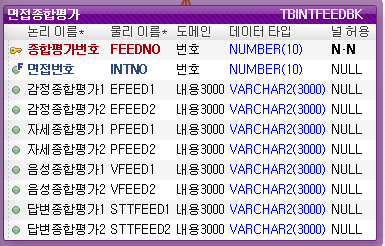

- 질문별 답변결과 (TBINTDETAIL)의 AI피드백디테일(AIFEEDBK) : 구체적인 피드백으로 매핑  
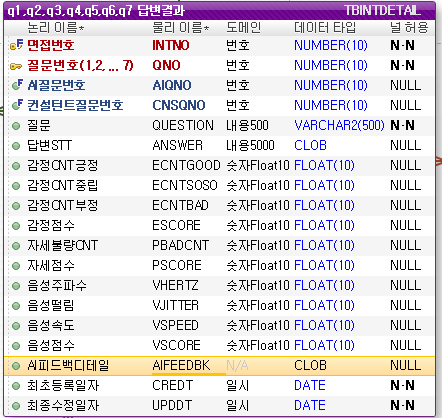

In [ ]:
def generate_strengths(analysis_result):
    """강점 피드백 생성"""
    job = analysis_result['job']
    matched_keywords = analysis_result['matched_keywords']

    if matched_keywords:
        strength = f"- {matched_keywords[0]}와(과) 관련된 내용을 언급하여 {job} 직무에 대한 이해도를 보여주었습니다."
    else:
        all_matched_keywords = analysis_result['all_matched_keywords']
        if all_matched_keywords:
            strength = f"- {all_matched_keywords[0]} 키워드를 언급하여 관련 역량을 보여주었습니다."
        else:
            sentiment = analysis_result['sentiment']
            strength = get_sentiment_feedback(sentiment)

    return "강점:\n" + strength if strength else ""

def generate_improvements(analysis_result):
    """개선점 피드백 생성"""
    job = analysis_result['job']
    missing_keywords = set(job_keywords.get(job, [])) - set(analysis_result['matched_keywords'])

    if missing_keywords:
        improvement = f"- {list(missing_keywords)[0]}에 대한 언급을 추가하면 {job} 직무와의 연관성을 더 잘 보여줄 수 있습니다."
    else:
        improvement = "- 더 구체적인 사례나 경험을 추가하면 답변의 설득력이 높아질 것입니다."

    return "개선점:\n" + improvement

In [ ]:
import random
import pandas as pd

# 질문 템플릿 정의
question_templates = {
    "background": {
        "c_person": [
            "본인의 성격 중 가장 큰 장점은 무엇이라고 생각하시나요? 그 이유는 무엇인가요?",
            "자신의 성격이 지원한 직무와 어떻게 연관되는지 설명해주세요."
        ],
        "c_private": [
            "지금까지의 경험 중 가장 큰 영향을 미친 사건은 무엇인가요?",
            "개인적인 경험이 직무 수행에 어떤 도움이 될 수 있을까요?"
        ],
        "c_value": [
            "본인의 가치관을 한 문장으로 표현한다면 어떻게 될까요?",
            "본인의 가치관이 업무에 어떻게 반영될 수 있을지 설명해주세요."
        ]
    },
    "etc": {
        "c_sincere_co": [
            "우리 회사에 지원한 이유는 무엇인가요?",
            "우리 회사의 어떤 점이 가장 매력적으로 느껴졌나요?"
        ],
        "c_sincere_job": [
            "이 직무를 선택한 이유는 무엇인가요?",
            "이 직무에서 성공하기 위해 필요한 자질은 무엇이라고 생각하시나요?"
        ]
    },
    "personality": {
        "c_adp": [
            "새로운 환경에 적응하는 본인만의 방법이 있다면 무엇인가요?",
            "예상치 못한 상황에 대처한 경험을 말씀해주세요."
        ],
        "c_chl": [
            "가장 큰 도전이었다고 생각하는 경험은 무엇인가요?",
            "실패를 극복하고 성공한 경험이 있다면 말씀해주세요."
        ],
        "c_confl_mg": [
            "팀 내 갈등 상황을 해결한 경험이 있나요? 어떻게 해결했나요?",
            "의견 충돌이 있을 때 어떻게 대처하시나요?"
        ],
        "c_cop": [
            "팀 프로젝트에서 본인의 역할은 주로 무엇인가요?",
            "협업 과정에서 가장 중요하게 생각하는 점은 무엇인가요?"
        ],
        "c_imp": [
            "최근에 새롭게 배운 기술이나 지식이 있다면 무엇인가요?",
            "자기계발을 위해 어떤 노력을 하고 계신가요?"
        ]
    }
}

In [ ]:
def generate_interview_question(general_job_data):
    if general_job_data.empty:
        return "데이터가 비어있어 질문을 생성할 수 없습니다."

    # 랜덤하게 하나의 행을 선택
    random_row = general_job_data.sample(n=1).iloc[0]

    category = random_row['category']
    expression = random_row['expression']

    if category in question_templates and expression in question_templates[category]:
        return random.choice(question_templates[category][expression])
    else:
        return f"{random_row['description']}에 대해 설명해주세요."

In [ ]:
def main():
    # 전체 데이터 로드
    full_intent_labels = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Project(InterviewData-Analysis)/data/full_intent_labels.tsv", sep="\t", encoding="utf8")

    # '전직무' 데이터 필터링
    general_job_data = full_intent_labels[full_intent_labels['job'] == '전 직무']

    if general_job_data.empty:
        print("'전 직무' 데이터가 없습니다.")
        return

    # 질문 생성
    question = generate_interview_question(general_job_data)
    print("생성된 면접 질문:", question)

    # 사용자 답변 입력 (주피터 노트북에서는 input() 대신 직접 답변을 입력하세요)
    answer = input("답변을 입력해 주세요: ")
    print("입력한 답변:", answer)

    # 답변 분석
    analysis_result = analyze_response(answer)

    # 피드백 생성
    feedback = generate_feedback(analysis_result)
    print("\n피드백:")
    print(feedback)

# 시뮬레이션 실행
main()

생성된 면접 질문: 이 직무에서 성공하기 위해 필요한 자질은 무엇이라고 생각하시나요?
답변을 입력해 주세요: 이 직무에서 성공하기 위해 필요한 자질은 문제 해결 능력, 협업과 소통 능력, 적극적인 학습 자세, 그리고 끈기와 인내심이라고 생각합니다.  문제 해결 능력: 이 직무는 복잡한 문제를 분석하고 해결하는 것이 핵심이기 때문에, 문제를 정의하고 다양한 해결책을 모색하는 능력이 매우 중요합니다. 예를 들어, 이전 프로젝트에서 시스템의 성능 문제를 해결하기 위해 다양한 접근 방식을 시도하고, 최적의 솔루션을 도출해낸 경험이 있습니다. 이러한 능력은 이 직무에서도 필수적입니다.  협업과 소통 능력: 다양한 팀원과 부서와 협력하여 목표를 달성하는 것이 중요합니다. 효과적인 소통을 통해 팀의 의견을 조율하고, 문제를 신속히 해결할 수 있는 능력이 필요합니다. 저는 팀 프로젝트에서 다양한 배경을 가진 팀원들과 협력하여 성공적인 결과를 얻은 경험이 있으며, 이는 이 직무에서도 큰 장점이 될 것입니다.  적극적인 학습 자세: 기술과 산업의 변화가 빠르기 때문에, 새로운 정보를 학습하고 기술을 업데이트하는 것이 중요합니다. 저는 최신 기술 동향을 지속적으로 학습하고, 이를 실무에 적용해 본 경험이 있습니다. 이러한 학습 자세는 이 직무에서 성공하기 위해 필수적입니다.  끈기와 인내심: 프로젝트가 복잡하거나 예상치 못한 어려움이 있을 때, 끈기와 인내심을 가지고 문제를 해결하는 것이 중요합니다. 어려운 문제에 직면했을 때, 포기하지 않고 해결책을 찾아 나가는 태도가 필요합니다. 이전 경험에서도 이러한 자세를 통해 도전적인 프로젝트를 성공적으로 마무리한 바 있습니다.  이러한 자질들은 이 직무에서 요구되는 기술적 능력과 함께 팀워크를 통해 목표를 달성하고, 지속적인 발전을 이루는 데 필수적이라고 생각합니다.
입력한 답변: 이 직무에서 성공하기 위해 필요한 자질은 문제 해결 능력, 협업과 소통 능력, 적극적인 학습 자세, 그리고 끈기와 인내심이라고 생각합니다.  문제 해결 능력

# 레이블 데이터 (full_intent_labels.tsv)를 이용한 AI 직무 면접 질문 생성
-  'job'이 '전 직무'가 아닌 데이터를 사용
- 회원의 희망직무에 따라 질문을 생성 (희망직무 종류 : IT/개발, 교육, 영업/마케팅,  기획/전략, 경영)

In [ ]:
import random
import pandas as pd

# 직무 매핑 정의
job_mapping = {
    "IT/개발": ["ICT", "R&D(개발/제조)"],
    "교육": ["공공/서비스"],
    "영업/마케팅": ["영업/판매", "경영/사무"],
    "기획/전략": ["경영/사무"],
    "경영": ["경영/사무"]
}

def generate_job_interview_question(full_intent_labels, selected_job):
    # '전 직무'가 아닌 데이터 필터링
    job_data = full_intent_labels[full_intent_labels['job'] != '전 직무']

    # 선택된 직무에 해당하는 데이터 필터링
    relevant_jobs = job_mapping.get(selected_job, [])
    relevant_data = job_data[job_data['job'].isin(relevant_jobs)]

    if relevant_data.empty:
        return "선택한 직무에 대한 질문을 생성할 수 없습니다."

    # 랜덤하게 하나의 행을 선택
    random_row = relevant_data.sample(n=1).iloc[0]

    # 질문 템플릿
    templates = [
        "당신의 {description} 능력을 보여줄 수 있는 경험에 대해 말씀해 주시겠습니까?",
        "{description}와 관련된 프로젝트 경험이 있다면 구체적인 사례를 들어 설명해 주세요.",
        "{job} 분야에서 {description}이(가) 왜 중요하다고 생각하시나요?",
        "{job} 직무에서 {description} 역량을 어떻게 발휘할 수 있을까요?",
        "{description}에 대한 본인의 강점은 무엇이라고 생각하시나요?"
    ]

    # 랜덤하게 템플릿 선택
    template = random.choice(templates)

    # 질문 생성
    question = template.format(description=random_row['description'], job=random_row['job'])

    return question

In [ ]:
def main():
    # 전체 데이터 로드
    full_intent_labels = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Project(InterviewData-Analysis)/data/full_intent_labels.tsv", sep="\t", encoding="utf8")

    # 희망 직무 선택
    print("희망 직무를 선택해주세요:")
    print("1. IT/개발")
    print("2. 교육")
    print("3. 영업/마케팅")
    print("4. 기획/전략")
    print("5. 경영")

    choice = input("번호를 입력해주세요: ")
    job_choices = ["IT/개발", "교육", "영업/마케팅", "기획/전략", "경영"]
    selected_job = job_choices[int(choice) - 1]

    # 질문 생성
    question = generate_job_interview_question(full_intent_labels, selected_job)
    print("\n생성된 면접 질문:", question)

    # 사용자 답변 입력
    answer = input("\n답변을 입력해 주세요: ")

    # 답변 분석
    analysis_result = analyze_response(answer)

    # 피드백 생성
    feedback = generate_feedback(analysis_result)
    print("\n피드백:")
    print(feedback)

# 시뮬레이션 실행
main()

희망 직무를 선택해주세요:
1. IT/개발
2. 교육
3. 영업/마케팅
4. 기획/전략
5. 경영
번호를 입력해주세요: 1

생성된 면접 질문: R&D(개발/제조) 직무에서 기술력 역량을 어떻게 발휘할 수 있을까요?

답변을 입력해 주세요: R&D 직무에서 기술력 역량을 발휘하는 방법으로는 문제 해결과 혁신적인 접근 방식, 협업과 지식 공유, 그리고 지속적인 학습과 개선을 들 수 있습니다.  첫째, 문제 해결과 혁신적인 접근 방식을 강조합니다. 개발 과정에서 마주하는 기술적 문제를 해결하기 위해, 기존의 방법론에 얽매이지 않고 창의적인 해결책을 모색합니다. 예를 들어, 최근 프로젝트에서 기존의 제조 공정에서 발생한 품질 문제를 해결하기 위해 다양한 실험을 통해 새로운 공정 조건을 제시하였고, 이를 통해 품질을 크게 개선한 경험이 있습니다. 이러한 접근 방식은 기술적 도전 과제를 해결하는 데 필수적입니다.  둘째, 협업과 지식 공유가 중요합니다. R&D 프로젝트는 다양한 분야의 전문 지식이 결합되어야 성공할 수 있습니다. 팀원들과의 긴밀한 협업과 지식 공유를 통해 서로의 아이디어를 발전시키고, 새로운 솔루션을 도출할 수 있습니다. 예를 들어, 프로젝트 초기 단계에서 설계팀과 제조팀 간의 정기적인 미팅을 통해 기술적 요구사항을 명확히 하고, 피드백을 반영하여 프로젝트를 효율적으로 진행한 경험이 있습니다.  셋째, 지속적인 학습과 개선을 통해 최신 기술과 트렌드를 반영합니다. 기술은 끊임없이 발전하고 있기 때문에, 최신 기술 동향을 학습하고 이를 프로젝트에 적용하는 것이 중요합니다. 저는 업계 관련 학회와 세미나에 참석하고, 최신 연구 결과를 분석하여 제 기술 역량을 지속적으로 향상시키고 있습니다. 예를 들어, 새로운 소재를 연구하여 제품의 성능을 개선하고, 제조 비용을 절감한 사례가 있습니다.  이러한 방법들을 통해 R&D 직무에서 제 기술력 역량을 효과적으로 발휘할 수 있습니다.

피드백:
답변 카테고리: 지식/기술 관련 역량
관련 역량/특성: 생산계획 (표현:

#  **면접의도분석모델(best_intent_model.h5), 레이블 데이터 (full_intent_labels.tsv)를 이용한 AI 모의 면접 질문 생성 (인성면접 5개, 직무면접 2개)** (최종 시뮬레이션)

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import load_model
from transformers import BertTokenizer, TFBertModel
import numpy as np
import pandas as pd
from konlpy.tag import Okt
from sklearn.feature_extraction.text import TfidfVectorizer
import random

# BERT 토크나이저 및 모델 로드
tokenizer = BertTokenizer.from_pretrained("klue/bert-base")
custom_objects = {'TFBertModel': TFBertModel}
with tf.keras.utils.custom_object_scope(custom_objects):
    model = load_model('/content/drive/MyDrive/Colab Notebooks/Project(InterviewData-Analysis)/Models/best_intent_model.h5')

In [ ]:
# 한국어 형태소 분석기 초기화
okt = Okt()

# 설정
max_len = 128  # 최대 문장 길이

# 레이블 데이터 로드
full_intent_labels = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Project(InterviewData-Analysis)/data/full_intent_labels.tsv", sep="\t", encoding="utf8")

In [ ]:
# 직무별 키워드 정의
job_keywords = {
    "경영/사무": ["분석", "전략", "의사소통", "성과", "브랜드", "세일즈", "대인관계", "기획", "관리", "목표", "리더십"],
    "공공/서비스": ["고객", "서비스", "윤리", "주도성", "스트레스", "대응", "VOC", "민원", "공익", "정책", "협력"],
    "R&D(개발/제조)": ["연구", "기술", "문제해결", "전문성", "정보수집", "방법론", "실적", "혁신", "개발", "실험", "분석"],
    "예술/디자인": ["창의", "트렌드", "감각", "표현", "브랜드", "프로세스", "선호", "미적", "시각", "컨셉", "아이디어"],
    "영업/판매": ["조율", "회계", "행정", "목표", "총괄", "비판적", "경험", "협상", "고객관리", "마케팅", "실적"],
    "ICT": ["프로그래밍", "개발", "장애대응", "기술", "보안", "HW", "SW", "네트워크", "데이터", "알고리즘", "시스템"],
    "제조/생산": ["교대근무", "생산계획", "장비운용", "성실성", "책임감", "품질관리", "안전", "효율성", "공정", "재고관리"]
}

# 카테고리 설명
category_descriptions = {
    "attitude": "태도 관련 역량",
    "background": "배경 및 경험",
    "etc": "기타 관련 사항",
    "personality": "성격 및 개인적 특성",
    "technology": "지식/기술 관련 역량"
}

# 불용어 목록
stop_words = ['있다', '없다', '하다', '되다', '이다', '돼다', '않다', '같다', '이', '그', '저', '것', '들', '등', '를', '을', '에', '의', '과', '로', '으로']

In [ ]:
# 직무 매핑 추가
job_mapping = {
    "IT/개발": ["ICT", "R&D(개발/제조)"],
    "교육": ["공공/서비스"],
    "영업/마케팅": ["영업/판매", "경영/사무"],
    "기획/전략": ["경영/사무"],
    "경영": ["경영/사무"]
}

# 인성 면접 템플릿
personality_templates = {
    "background": {
        "c_person": [
            "본인의 성격 중 가장 큰 장점은 무엇이라고 생각하시나요? 그 이유는 무엇인가요?",
            "자신의 성격이 지원한 직무와 어떻게 연관되는지 설명해주세요."
        ],
        "c_private": [
            "지금까지의 경험 중 가장 큰 영향을 미친 사건은 무엇인가요?",
            "개인적인 경험이 직무 수행에 어떤 도움이 될 수 있을까요?"
        ],
        "c_value": [
            "본인의 가치관을 한 문장으로 표현한다면 어떻게 될까요?",
            "본인의 가치관이 업무에 어떻게 반영될 수 있을지 설명해주세요."
        ]
    },
    "etc": {
        "c_sincere_co": [
            "우리 회사에 지원한 이유는 무엇인가요?",
            "우리 회사의 어떤 점이 가장 매력적으로 느껴졌나요?"
        ],
        "c_sincere_job": [
            "이 직무를 선택한 이유는 무엇인가요?",
            "이 직무에서 성공하기 위해 필요한 자질은 무엇이라고 생각하시나요?"
        ]
    },
    "personality": {
        "c_adp": [
            "새로운 환경에 적응하는 본인만의 방법이 있다면 무엇인가요?",
            "예상치 못한 상황에 대처한 경험을 말씀해주세요."
        ],
        "c_chl": [
            "가장 큰 도전이었다고 생각하는 경험은 무엇인가요?",
            "실패를 극복하고 성공한 경험이 있다면 말씀해주세요."
        ],
        "c_confl_mg": [
            "팀 내 갈등 상황을 해결한 경험이 있나요? 어떻게 해결했나요?",
            "의견 충돌이 있을 때 어떻게 대처하시나요?"
        ],
        "c_cop": [
            "팀 프로젝트에서 본인의 역할은 주로 무엇인가요?",
            "협업 과정에서 가장 중요하게 생각하는 점은 무엇인가요?"
        ],
        "c_imp": [
            "최근에 새롭게 배운 기술이나 지식이 있다면 무엇인가요?",
            "자기계발을 위해 어떤 노력을 하고 계신가요?"
        ]
    }
}

# 직무 면접 템플릿
job_templates = [
    "당신의 {description} 능력을 보여줄 수 있는 경험에 대해 말씀해 주시겠습니까?",
    "{description}와 관련된 프로젝트 경험이 있다면 구체적인 사례를 들어 설명해 주세요.",
    "{job} 분야에서 {description}이(가) 왜 중요하다고 생각하시나요?",
    "{job} 직무에서 {description} 역량을 어떻게 발휘할 수 있을까요?",
    "{description}에 대한 본인의 강점은 무엇이라고 생각하시나요?"
]

In [ ]:
def predict(sentence):
    """주어진 문장에 대해 예측을 수행하는 함수"""
    inputs = tokenizer(
        sentence,
        max_length=max_len,
        padding='max_length',
        truncation=True,
        return_tensors='tf'
    )
    out = model({'input_ids': inputs['input_ids'], 'attention_mask': inputs['attention_mask']})
    logits = out.numpy()
    predicted_class = np.argmax(logits, axis=1)[0]
    prediction_info = full_intent_labels.iloc[predicted_class]
    return prediction_info['category'], prediction_info['expression'], prediction_info['description'], prediction_info['job']

In [ ]:
def analyze_response(sentence):
    """주어진 문장에 대해 종합적인 분석을 수행하는 함수"""
    category, expression, description, job = predict(sentence)
    tfidf = TfidfVectorizer(max_features=10, stop_words=stop_words)
    tfidf_matrix = tfidf.fit_transform([sentence])
    important_words = tfidf.get_feature_names_out()
    matched_keywords = [keyword for keyword in job_keywords.get(job, []) if keyword in sentence]
    all_matched_keywords = [keyword for job_kw in job_keywords.values() for keyword in job_kw if keyword in sentence]
    return {
        'category': category,
        'expression': expression,
        'job': job,
        'description': description,
        'important_words': important_words,
        'matched_keywords': matched_keywords,
        'all_matched_keywords': all_matched_keywords
    }

In [ ]:
def generate_strengths(analysis_result):
    """강점 피드백 생성"""
    job = analysis_result['job']
    matched_keywords = analysis_result['matched_keywords']

    if matched_keywords:
        strength = f"- {matched_keywords[0]}와(과) 관련된 내용을 언급하여 {job} 직무에 대한 이해도를 보여주었습니다."
    else:
        all_matched_keywords = analysis_result['all_matched_keywords']
        if all_matched_keywords:
            strength = f"- {all_matched_keywords[0]} 키워드를 언급하여 관련 역량을 보여주었습니다."
        else:
            strength = "- 답변에서 직무 관련 키워드를 찾지 못했습니다. 더 구체적인 경험이나 역량을 언급해보세요."

    return "강점:\n" + strength

In [ ]:
def generate_improvements(analysis_result):
    """개선점 피드백 생성"""
    job = analysis_result['job']
    missing_keywords = set(job_keywords.get(job, [])) - set(analysis_result['matched_keywords'])

    if missing_keywords:
        improvement = f"- {list(missing_keywords)[0]}에 대한 언급을 추가하면 {job} 직무와의 연관성을 더 잘 보여줄 수 있습니다."
    else:
        improvement = "- 더 구체적인 사례나 경험을 추가하면 답변의 설득력이 높아질 것입니다."

    return "개선점:\n" + improvement

In [ ]:
def generate_feedback(analysis_result):
    """분석 결과를 바탕으로 피드백을 생성하는 함수"""
    feedback_parts = [
        generate_strengths(analysis_result),
        generate_improvements(analysis_result)
    ]
    return "\n\n".join(feedback_parts)

In [ ]:
def generate_personality_question(data):
    """인성 면접 질문 생성 함수"""
    random_row = data.sample(n=1).iloc[0]
    category = random_row['category']
    expression = random_row['expression']

    if category in personality_templates and expression in personality_templates[category]:
        return random.choice(personality_templates[category][expression])
    else:
        return f"{random_row['description']}에 대해 설명해주세요."

In [ ]:
def generate_job_question(data, job):
    """직무 면접 질문 생성 함수"""
    random_row = data.sample(n=1).iloc[0]
    template = random.choice(job_templates)
    return template.format(description=random_row['description'], job=job)

In [ ]:
def generate_interview_questions(full_intent_labels, selected_job, num_personality=5, num_job=2):
    """인성 및 직무 면접 질문 생성 함수"""
    personality_data = full_intent_labels[full_intent_labels['job'] == '전 직무']
    job_data = full_intent_labels[full_intent_labels['job'].isin(job_mapping[selected_job])]

    # 중복을 피하기 위해 set을 사용
    personality_questions = set()
    job_questions = set()

    while len(personality_questions) < num_personality:
        question = generate_personality_question(personality_data)
        personality_questions.add(question)

    while len(job_questions) < num_job:
        question = generate_job_question(job_data, selected_job)
        job_questions.add(question)

    return list(personality_questions) + list(job_questions)

In [ ]:
def conduct_interview(full_intent_labels, selected_job):
    """면접 진행 함수"""
    questions = generate_interview_questions(full_intent_labels, selected_job)
    results = []

    for i, question in enumerate(questions, 1):
        print(f"\n질문 {i}: {question}")
        answer = input("답변: ")
        analysis_result = analyze_response(answer)
        strength = generate_strengths(analysis_result)
        improvement = generate_improvements(analysis_result)
        results.append((question, answer, strength, improvement))
        print(strength)
        print(improvement)

    return results

In [ ]:
def generate_overall_feedback(results):
    strengths = []
    improvements = []

    for _, _, strength, improvement in results:
        if strength:
            strengths.append(strength.split('\n')[1].strip('- '))  # "강점:" 제외하고 앞의 '- ' 제거
        if improvement:
            improvements.append(improvement.split('\n')[1].strip('- '))  # "개선점:" 제외하고 앞의 '- ' 제거

    overall_feedback = "종합 평가: "

    if strengths:
        overall_feedback += f"면접에서 {', '.join(random.sample(strengths, min(3, len(strengths))))} 등의 강점을 보여주셨고, "

    if improvements:
        overall_feedback += f"{', '.join(random.sample(improvements, min(3, len(improvements))))} 등의 부분에서 개선의 여지가 있습니다. "

    overall_feedback += "전반적으로 좋은 모습을 보여주셨으며, 언급된 개선점들을 고려하여 앞으로 더욱 발전된 모습을 보여주시기 바랍니다."

    return overall_feedback

In [ ]:
def conduct_interview_simulation(full_intent_labels, selected_job):
    print(f"\n선택한 직무: {selected_job}")
    print("면접을 시작합니다. 총 7개의 질문에 답변해 주세요.")

    questions = generate_interview_questions(full_intent_labels, selected_job)
    results = []

    for i, question in enumerate(questions, 1):
        print(f"\n질문 {i}: {question}")
        answer = input("답변: ")
        analysis_result = analyze_response(answer)
        feedback = generate_feedback(analysis_result)
        strength = generate_strengths(analysis_result)
        improvement = generate_improvements(analysis_result)
        results.append((question, answer, strength, improvement))
        print("\n피드백:")
        print(feedback)

    print("\n면접이 종료되었습니다. 종합 평가를 생성합니다.")
    overall_feedback = generate_overall_feedback(results)
    print("\n종합 평가:")
    print(overall_feedback)

def main():
    full_intent_labels = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Project(InterviewData-Analysis)/data/full_intent_labels.tsv", sep="\t", encoding="utf8")

    print("희망 직무를 선택해주세요:")
    print("1. IT/개발")
    print("2. 교육")
    print("3. 영업/마케팅")
    print("4. 기획/전략")
    print("5. 경영")

    choice = input("번호를 입력해주세요: ")
    job_choices = ["IT/개발", "교육", "영업/마케팅", "기획/전략", "경영"]
    selected_job = job_choices[int(choice) - 1]

    conduct_interview_simulation(full_intent_labels, selected_job)

if __name__ == "__main__":
    main()

희망 직무를 선택해주세요:
1. IT/개발
2. 교육
3. 영업/마케팅
4. 기획/전략
5. 경영
번호를 입력해주세요: 1

선택한 직무: IT/개발
면접을 시작합니다. 총 7개의 질문에 답변해 주세요.

질문 1: 우리 회사에 지원한 이유는 무엇인가요?
답변: 저는 귀사의 혁신적인 기술 개발과 도전적인 프로젝트에 깊이 감명받았습니다. 특히, 귀사가 추진하는 최신 기술 트렌드와 지속 가능한 개발 전략에 큰 매력을 느꼈습니다. 제 경험과 기술력을 활용하여 이러한 프로젝트에 기여하고, 함께 성장할 수 있는 기회를 갖고 싶습니다.

피드백:
강점:
- 전략 키워드를 언급하여 관련 역량을 보여주었습니다.

개선점:
- 더 구체적인 사례나 경험을 추가하면 답변의 설득력이 높아질 것입니다.

질문 2: 본인의 가치관을 한 문장으로 표현한다면 어떻게 될까요?
답변: 제 가치관은 기술을 통해 문제를 해결하고, 혁신을 지속하며, 항상 사용자의 요구를 최우선으로 고려하는 것입니다.

피드백:
강점:
- 기술 키워드를 언급하여 관련 역량을 보여주었습니다.

개선점:
- 더 구체적인 사례나 경험을 추가하면 답변의 설득력이 높아질 것입니다.

질문 3: 팀 내 갈등 상황을 해결한 경험이 있나요? 어떻게 해결했나요?
답변: 네, 팀 내에서 기술적 접근 방식에 대한 의견 차이로 갈등이 있었던 상황이 있었습니다. 이 문제를 해결하기 위해, 먼저 모든 팀원과 개별적으로 면담하여 각자의 의견과 우려를 충분히 이해했습니다. 이후, 전체 회의를 통해 문제를 공유하고, 각 의견의 장단점을 비교하여 합리적인 타협점을 찾았습니다. 이러한 과정을 통해 팀원들의 신뢰를 얻고, 공동의 목표를 향해 효율적으로 협력할 수 있었습니다.

피드백:
강점:
- 목표 키워드를 언급하여 관련 역량을 보여주었습니다.

개선점:
- 더 구체적인 사례나 경험을 추가하면 답변의 설득력이 높아질 것입니다.

질문 4: 최근에 새롭게 배운 기술이나 지식이 있다면 무엇인가요?
답변: 최근에 새롭게 배운 기술은 머신러닝 프레임워크인

## 인성 면접 질문만 따로 생성
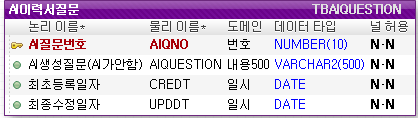

# 직무 면접 질문만 따로 생성
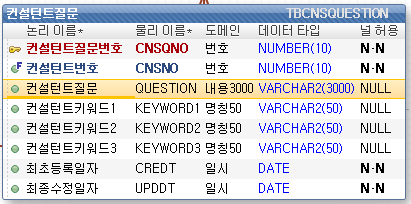

# Django 에서~



```
# config.py
import json

with open('job_keywords.json', 'r') as f:
    JOB_KEYWORDS = json.load(f)

with open('category_descriptions.json', 'r') as f:
    CATEGORY_DESCRIPTIONS = json.load(f)

```





```
# model.py
import tensorflow as tf
from transformers import BertTokenizer, TFBertModel

class InterviewModel:
    def __init__(self, model_path):
        self.tokenizer = BertTokenizer.from_pretrained("klue/bert-base")
        self.model = self.load_model(model_path)

    def load_model(self, model_path):
        custom_objects = {'TFBertModel': TFBertModel}
        with tf.keras.utils.custom_object_scope(custom_objects):
            return tf.keras.models.load_model(model_path)

    def predict(self, sentence):
        # 예측 로직
        pass
```





```
# analysis.py
from konlpy.tag import Okt
from sklearn.feature_extraction.text import TfidfVectorizer

class TextAnalyzer:
    def __init__(self):
        self.okt = Okt()
        self.tfidf = TfidfVectorizer(max_features=10, stop_words=STOP_WORDS)

    def analyze(self, sentence):
        # 분석 로직
        pass

```





```
# feedback.py
class FeedbackGenerator:
    @staticmethod
    def generate(analysis_result):
        # 피드백 생성 로직
        pass
```





```
# main.py
from flask import Flask, jsonify
from flask_cors import CORS
import sqlite3
from model import InterviewModel
from analysis import TextAnalyzer
from feedback import FeedbackGenerator

app = Flask(__name__)
CORS(app)

model = InterviewModel('path/to/model.h5')
analyzer = TextAnalyzer()
feedback_gen = FeedbackGenerator()

def get_unprocessed_interviews():
    """처리되지 않은 인터뷰 결과를 가져옵니다."""
    conn = sqlite3.connect('interview_data.db')
    cursor = conn.cursor()
    cursor.execute("SELECT id, stt_text FROM interview_results WHERE processed = 0")
    results = cursor.fetchall()
    conn.close()
    return results

def save_feedback(id, feedback):
    """피드백을 저장하고 처리 상태를 업데이트합니다."""
    conn = sqlite3.connect('interview_data.db')
    cursor = conn.cursor()
    cursor.execute("UPDATE interview_results SET feedback = ?, processed = 1 WHERE id = ?", (feedback, id))
    conn.commit()
    conn.close()

@app.route('/process_interviews', methods=['POST'])
def process_interviews():
    interviews = get_unprocessed_interviews()
    processed_count = 0

    for id, stt_text in interviews:
        analysis = analyzer.analyze(stt_text)
        feedback = feedback_gen.generate(analysis)
        save_feedback(id, feedback)
        processed_count += 1

    return jsonify({"message": f"Processed {processed_count} interviews"})

@app.route('/get_interviews', methods=['GET'])
def get_interviews():
    conn = sqlite3.connect('interview_data.db')
    cursor = conn.cursor()
    cursor.execute("SELECT id, stt_text, feedback FROM interview_results WHERE processed = 1")
    results = cursor.fetchall()
    conn.close()

    interviews = [{"id": row[0], "stt_text": row[1], "feedback": row[2]} for row in results]
    return jsonify(interviews)

if __name__ == "__main__":
    app.run(debug=True)
```



# Vue 에서~



```
<!-- InterviewResults.vue -->
<template>
  <div>
    <button @click="processInterviews">인터뷰 처리</button>
    <button @click="getInterviews">결과 가져오기</button>
    <div v-for="interview in interviews" :key="interview.id">
      <h3>인터뷰 ID: {{ interview.id }}</h3>
      <p><strong>STT 텍스트:</strong> {{ interview.stt_text }}</p>
      <p><strong>피드백:</strong> {{ interview.feedback }}</p>
    </div>
  </div>
</template>

<script>
import axios from 'axios';

export default {
  data() {
    return {
      interviews: []
    }
  },
  methods: {
    async processInterviews() {
      try {
        const response = await axios.post('http://localhost:5000/process_interviews');
        alert(response.data.message);
      } catch (error) {
        console.error('인터뷰 처리 중 오류 발생:', error);
      }
    },
    async getInterviews() {
      try {
        const response = await axios.get('http://localhost:5000/get_interviews');
        this.interviews = response.data;
      } catch (error) {
        console.error('인터뷰 결과 가져오기 중 오류 발생:', error);
      }
    }
  }
}
</script>
```

